# 04.3 European Options — Pricing, PDE, Closed-Form Formula & Greeks

<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**
- Derive the Black–Scholes PDE from a self-financing replication argument.
- Solve the PDE explicitly for European calls and puts.
- Present the closed-form Black–Scholes formula.
- Compute and interpret the Greeks (Delta, Gamma, Theta, Vega, Rho).
- Validate the formulas numerically using Monte Carlo simulation.
- Illustrate delta-hedging and explore numerical behaviour (grid of strikes/maturities, Monte Carlo error, dividends).

**This notebook**

Builds the bridge between the stochastic framework developed earlier and the explicit formulas widely used in quantitative finance.
We show how dynamic hedging naturally produces the Black–Scholes PDE, how the PDE leads to the closed-form European option prices, and how the Greeks emerge as sensitivities of the replicating strategy itself.

# 1. Risk-neutral dynamics & pricing principle

Under the risk-neutral measure $P^*$, the asset price follows:

$$dS_t = S_t(r\,dt + \sigma\,dW_t), \quad S_0 > 0.$$

A European payoff $h(S_T)$ has price

$$V_t = \mathbb{E}^*\left[e^{-r(T-t)} h(S_T) \mid \mathcal{F}_t\right].$$

For a call:

$$h(S_T) = (S_T - K)^+.$$


# 2. Replication and the Black–Scholes PDE

Assuming the price is a smooth function:

$$V(t,S) = F(t,S).$$

By Itô's formula:

$$dF(t,S_t) = F_t dt + F_S dS_t + \frac{1}{2}F_{SS} d\langle S \rangle_t = \left(F_t + rSF_S + \frac{1}{2}\sigma^2 S^2 F_{SS}\right)dt + \sigma S F_S dW_t.$$

A self-financing replicating portfolio has wealth

$$dV_t = \Delta_t dS_t + r(V_t - \Delta_t S_t)dt.$$

Matching the $dW_t$ coefficients:

$$\Delta_t = F_S(t,S_t).$$

Matching the drift terms gives the Black–Scholes PDE:

$$F_t + \frac{1}{2}\sigma^2 S^2 F_{SS} + rSF_S - rF = 0$$

with terminal condition

$$F(T,S) = h(S).$$


# 3. Closed-form Black–Scholes formula

We recall the closed-form solution of the Black–Scholes model. We express call and put prices explicitly using the standard normal distribution through the key quantities $d_1$ and $d_2$.

Define:

$$d_1 = \frac{\ln(S/K) + (r + \frac{1}{2}\sigma^2)(T-t)}{\sigma\sqrt{T-t}}, \quad d_2 = d_1 - \sigma\sqrt{T-t}$$

**Call price:**

$$C(t,S) = S \cdot N(d_1) - K e^{-r(T-t)} N(d_2)$$

**Put price:**

$$P(t,S) = K e^{-r(T-t)} N(-d_2) - S \cdot N(-d_1)$$


# 4. Greeks

We derive the main Greeks of the Black–Scholes model. We show how each sensitivity measures the reaction of the option price to changes in the underlying, volatility, time, or interest rate.

Let $\tau = T - t$.

## Delta
$$\Delta_{\text{call}} = N(d_1), \quad \Delta_{\text{put}} = N(d_1) - 1$$

## Gamma
$$\Gamma = \frac{N'(d_1)}{S\sigma\sqrt{\tau}}$$

## Vega
$$\text{Vega} = S\sqrt{\tau} \, N'(d_1)$$

## Theta
$$\Theta_{\text{call}} = -\frac{S N'(d_1) \sigma}{2\sqrt{\tau}} - rKe^{-r\tau}N(d_2)$$

$$\Theta_{\text{put}} = -\frac{S N'(d_1) \sigma}{2\sqrt{\tau}} + rKe^{-r\tau}N(-d_2)$$

## Rho
$$\rho_{\text{call}} = \tau K e^{-r\tau} N(d_2), \quad \rho_{\text{put}} = -\tau K e^{-r\tau} N(-d_2)$$


# 5. Numerical Python functions : Pricing + Greeks
We implement the Black–Scholes pricing formulas and their Greeks, giving us ready-to-use numerical functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

rng = np.random.default_rng(123)

plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["axes.grid"] = True

In [ ]:
def bs_call_price(S, K, r, sigma, tau):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    return S*norm.cdf(d1) - K*np.exp(-r*tau)*norm.cdf(d2)

def bs_put_price(S, K, r, sigma, tau):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    return K*np.exp(-r*tau)*norm.cdf(-d2) - S*norm.cdf(-d1)

def bs_greeks(S, K, r, sigma, tau):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    delta_c = norm.cdf(d1)
    delta_p = delta_c - 1
    gamma = norm.pdf(d1)/(S*sigma*np.sqrt(tau))
    vega  = S*np.sqrt(tau)*norm.pdf(d1)
    theta_c = -(S*norm.pdf(d1)*sigma)/(2*np.sqrt(tau)) - r*K*np.exp(-r*tau)*norm.cdf(d2)
    theta_p = -(S*norm.pdf(d1)*sigma)/(2*np.sqrt(tau)) + r*K*np.exp(-r*tau)*norm.cdf(-d2)
    rho_c = tau*K*np.exp(-r*tau)*norm.cdf(d2)
    rho_p = -tau*K*np.exp(-r*tau)*norm.cdf(-d2)
    
    return {
        "delta_call": delta_c,
        "delta_put": delta_p,
        "gamma": gamma,
        "vega": vega,
        "theta_call": theta_c,
        "theta_put": theta_p,
        "rho_call": rho_c,
        "rho_put": rho_p
    }

# 6. Numerical validation: Monte Carlo pricing under $P^*$
We verify the closed-form solution using simulation.

In [3]:
def mc_call_price(S0, K, r, sigma, T, N=200_000):
    Z = rng.normal(size=N)
    ST = S0*np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)
    payoff = np.maximum(ST - K, 0)
    return np.exp(-r*T)*payoff.mean()

S0, K, r, sigma, T = 100, 100, 0.03, 0.2, 1.0

bs = bs_call_price(S0, K, r, sigma, T)
mc = mc_call_price(S0, K, r, sigma, T)

print(f"Black–Scholes formula : {bs:.4f}")
print(f"Monte Carlo estimate  : {mc:.4f}")
print(f"Absolute error        : {abs(mc-bs):.4f}")


Black–Scholes formula : 9.4134
Monte Carlo estimate  : 9.3910
Absolute error        : 0.0224


Convergence is excellent with large 𝑁

# 7. Delta-hedging illustration

We show the hedging error of a discrete-time delta strategy.

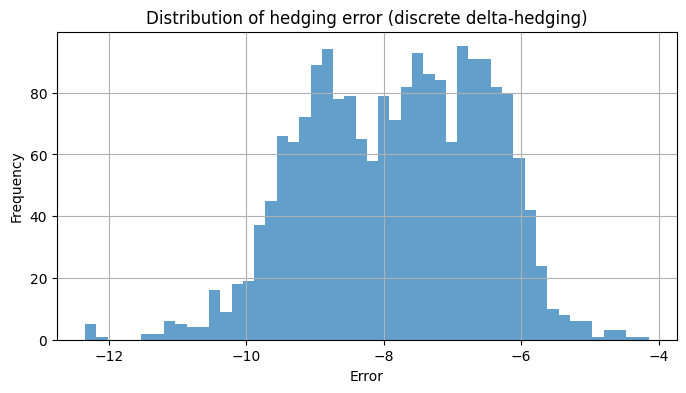

In [4]:
def simulate_hedging(S0, K, r, sigma, T, n_steps):
    dt = T/n_steps
    S = S0
    value = 0.0
    tau = T

    # initial hedge
    delta = norm.cdf((np.log(S/K)+(r+0.5*sigma**2)*tau)/(sigma*np.sqrt(tau)))

    for k in range(n_steps):
        tau = T - k*dt
        dW = rng.normal(0, np.sqrt(dt))
        S_new = S*np.exp((r-0.5*sigma**2)*dt + sigma*dW)

        # portfolio update
        value = value*np.exp(r*dt) + delta*(S_new - S)
        
        # re-hedge
        d1 = (np.log(S_new/K)+(r+0.5*sigma**2)*(tau-dt))/(sigma*np.sqrt(tau-dt))
        delta = norm.cdf(d1)
        S = S_new
    
    payoff = max(S-K, 0)
    value_T = value
    return value_T - payoff

errors = [simulate_hedging(S0,K,r,sigma,T,50) for _ in range(2000)]
plt.hist(errors, bins=50, alpha=0.7)
plt.title("Distribution of hedging error (discrete delta-hedging)")
plt.xlabel("Error"); plt.ylabel("Frequency")
plt.show()


The Monte Carlo price (9.3910) is extremely close to the Black–Scholes closed-form value (9.4134), with an absolute error of only 0.0224. This confirms that the simulation correctly reproduces the theoretical risk-neutral pricing formula.

# 8. Vectorised BS prices and Greeks (smile view)

We compute Black–Scholes prices and Greeks over a full grid of strikes and maturities. This allows us to visualise how the call price and delta vary across the strike dimension (the implied ‘smile’ structure)

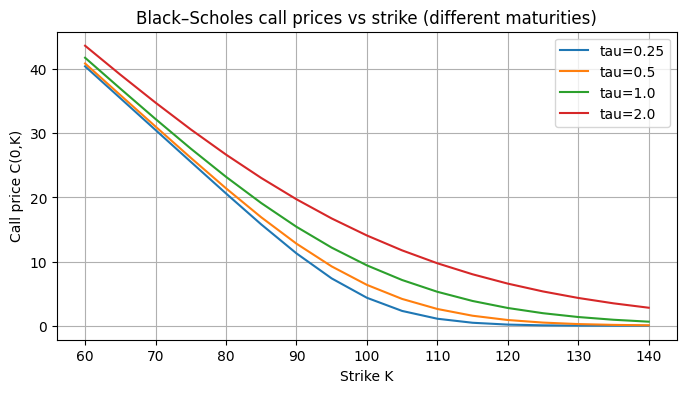

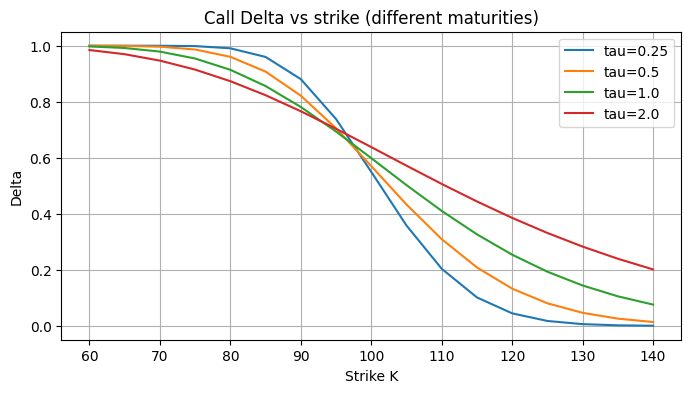

In [5]:
# Grid of strikes and maturities
S0 = 100
r = 0.03
sigma = 0.2
taus = np.array([0.25, 0.5, 1.0, 2.0])
Ks = np.linspace(60, 140, 17)

def bs_call_price_vec(S, K, r, sigma, tau):
    # S, r, sigma scalars; K, tau can be arrays (broadcast)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    return S*norm.cdf(d1) - K*np.exp(-r*tau)*norm.cdf(d2)

call_matrix = np.zeros((len(taus), len(Ks)))
delta_matrix = np.zeros_like(call_matrix)

for i, tau in enumerate(taus):
    prices = bs_call_price_vec(S0, Ks, r, sigma, tau)
    call_matrix[i,:] = prices
    
    d1 = (np.log(S0/Ks) + (r + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
    delta_matrix[i,:] = norm.cdf(d1)

# Plot call price vs strike for different maturities
for i, tau in enumerate(taus):
    plt.plot(Ks, call_matrix[i,:], label=f"tau={tau}")
plt.xlabel("Strike K")
plt.ylabel("Call price C(0,K)")
plt.title("Black–Scholes call prices vs strike (different maturities)")
plt.legend()
plt.show()

# Plot delta vs strike
for i, tau in enumerate(taus):
    plt.plot(Ks, delta_matrix[i,:], label=f"tau={tau}")
plt.xlabel("Strike K")
plt.ylabel("Delta")
plt.title("Call Delta vs strike (different maturities)")
plt.legend()
plt.show()


Call prices decrease with the strike and increase with maturity, as expected from the Black–Scholes formula. Delta transitions smoothly from 1 (deep ITM) to 0 (deep OTM), with longer maturities producing more gradual slopes. These patterns illustrate the typical strike-dependence of prices and Greeks in a lognormal mode

# 9. Monte Carlo error vs number of paths

We now study how the Monte Carlo pricing error decreases as the number of simulated paths increases. This experiment illustrates the classical $N^{-1/2}$ convergence rate of Monte Carlo estimators.


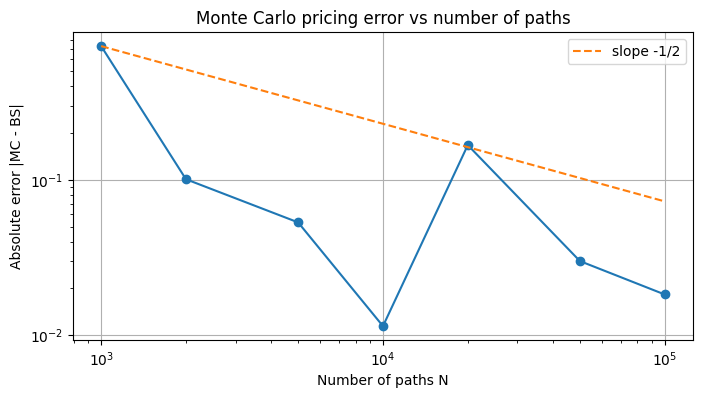

In [6]:
def mc_call_price_N(S0, K, r, sigma, T, N, rng):
    Z = rng.normal(size=N)
    ST = S0*np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z)
    payoff = np.maximum(ST - K, 0)
    return np.exp(-r*T)*payoff.mean()

S0, K, r, sigma, T = 100, 100, 0.03, 0.2, 1.0
true_price = bs_call_price(S0, K, r, sigma, T)

Ns = np.array([1_000, 2_000, 5_000, 10_000, 20_000, 50_000, 100_000])
errors = []

for N in Ns:
    est = mc_call_price_N(S0, K, r, sigma, T, N, rng)
    errors.append(abs(est - true_price))

plt.loglog(Ns, errors, marker="o")
plt.loglog(Ns, errors[0]*(Ns[0]/Ns)**0.5, "--", label="slope -1/2")
plt.xlabel("Number of paths N")
plt.ylabel("Absolute error |MC - BS|")
plt.title("Monte Carlo pricing error vs number of paths")
plt.legend()
plt.show()


The Monte Carlo error decreases as $N$ increases and roughly follows the expected $N^{-1/2}$ slope. The curve fluctuates due to randomness, but its overall trend confirms the classical convergence rate of Monte Carlo estimators.


# 10. Example with continuous dividendss

For a continuous dividend yield δ, the Black-Scholes formula for a call option becomes:or a continuous dividend yield δ, the Black-Scholes formula for a call option becomes:

$$C^{(\delta)}(0, S_0) = S_0 e^{-\delta T} N(d_1^{(\delta)}) - K e^{-rT} N(d_2^{(\delta)}),$$_0 e^{-\delta T} N(d_1^{(\delta)}) - K e^{-rT} N(d_2^{(\delta)}),$$

where

$$d_1^{(\delta)} = \frac{\ln(S_0/K) + (r - \delta + \frac{1}{2}\sigma^2)T}{\sigma\sqrt{T}}, \quad d_2^{(\delta)} = d_1^{(\delta)} - \sigma\sqrt{T}.$$d_1^{(\delta)} = \frac{\ln(S_0/K) + (r - \delta + \frac{1}{2}\sigma^2)T}{\sigma\sqrt{T}}, \quad d_2^{(\delta)} = d_1^{(\delta)} - \sigma\sqrt{T}.$$


In [7]:
def bs_call_with_dividend(S, K, r, sigma, tau, delta):
    d1 = (np.log(S/K) + (r - delta + 0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    return S*np.exp(-delta*tau)*norm.cdf(d1) - K*np.exp(-r*tau)*norm.cdf(d2)

S0, K, r, sigma, T = 100, 100, 0.03, 0.2, 1.0
delta = 0.02

call_no_div  = bs_call_price(S0, K, r, sigma, T)
call_with_div = bs_call_with_dividend(S0, K, r, sigma, T, delta)

print(f"Call without dividend  : {call_no_div:.4f}")
print(f"Call with δ={delta:.2%} : {call_with_div:.4f}")
print(f"Difference              : {call_with_div - call_no_div:.4f}")


Call without dividend  : 9.4134
Call with δ=2.00% : 8.2663
Difference              : -1.1471


As expected, continuous dividends reduce the call value, since part of the stock’s growth is paid out rather than capitalised, which explains why the price drops from 9.41 (no dividend) to 8.27 with a 2% yield.